In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
sys.path.insert(0, "/so/home/jsugiyama/git/sotodlib/")
import sotodlib
from sotodlib.tod_ops import fft_ops, detrend_tod
from sotodlib import core
from sotodlib import hwp
from sotodlib.io import load_smurf as ls
from sotodlib.io.load_smurf import Observations, Files, TuneSets, Tunes
from sotodlib.io import g3tsmurf_utils

In [2]:
ctx_file = '/so/metadata/satp3/contexts/use_this.yaml'
ctx = core.Context(ctx_file)
obs_id = 'obs_1709601492_satp3_1111111'
ws = 'ws0'
bandpass = 'f150'
meta = ctx.get_meta(obs_id, dets={'wafer_slot': 'ws0', 'wafer.bandpass': 'f150'})
aman = ctx.get_obs(meta)

In [3]:
for idet in range(aman.signal.shape[0]) : 
    aman.signal[idet] *= aman.det_cal.phase_to_pW[idet]

In [4]:
detrend_tod(aman)

array([[-0.02564496, -0.02735919, -0.02968833, ..., -0.03053415,
        -0.02829826, -0.02548477],
       [-0.03261045, -0.03135622, -0.03046858, ..., -0.03714111,
        -0.03748849, -0.0380674 ],
       [-0.03813046, -0.0365559 , -0.03528485, ..., -0.04219781,
        -0.04307051, -0.04293773],
       ...,
       [-0.03441855, -0.03475183, -0.03419667, ..., -0.02635875,
        -0.02767313, -0.02995005],
       [-0.03448242, -0.03484531, -0.03401093, ..., -0.02638803,
        -0.02667837, -0.0278213 ],
       [-0.03572106, -0.03510451, -0.03366596, ..., -0.02531236,
        -0.02594626, -0.02711093]], dtype=float32)

In [32]:
hwp.demod_tod(aman, hwp_angle=aman.hwp_solution.hwp_angle)

ValueError: Key conflict: more than one merge target shares keys: {'dsT'}

In [6]:
signal=aman.signal
freqs, pxx = fft_ops.calc_psd(
            aman, signal=signal, timestamps=aman.timestamps, max_samples=2**20, merge=True, nperseg=len(aman.timestamps)
        )

In [37]:
signal=aman.demodQ
freqs_demodQ, pxx_demodQ = fft_ops.calc_psd(
            aman, signal=signal, timestamps=aman.timestamps, max_samples=2**20, merge=False, nperseg=len(aman.timestamps)
        )

In [7]:
# import hwp frequency
hwp_freq = np.median(aman['hwp_solution']['hwp_rate_1'])

## New function "calc_masked_psd"

"calc_masked_psd" masks hwpss or single peak in the given PSD.\
This enables applying 1/f curve for the PSD with peaks.\
You can adjust the masking range of hwpss and single peak in case of bad weather.

In [8]:
f_mask, pxx_mask = fft_ops.calc_masked_psd(aman, hwpss=True, hwp_freq=hwp_freq,peak=True, peak_freq=26, peak_width=(-2, +6), merge=False)

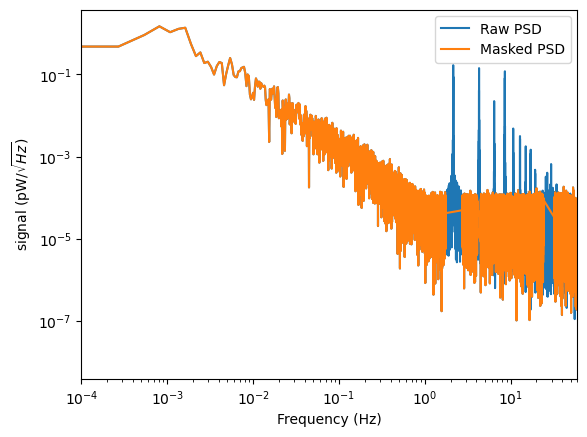

In [96]:
plt.figure()
plt.loglog(aman.freqs, np.sqrt(aman.Pxx[3]), label="Raw PSD")
masked_p = pxx_mask[3]
plt.loglog(f_mask, np.sqrt(masked_p), label="Masked PSD")
plt.xlabel('Frequency (Hz)')
plt.xlim(1E-4, 60)
plt.ylabel('signal (pW/$\sqrt{Hz}$)')
plt.legend()

## New function "calc_binned_psd"

"binning_psd" returns the binned PSD.\
The parameters "unbinned_mode" and "base" changes the number of first un-binned modes and binning width.

In [19]:
f_binned, pxx_binned = fft_ops.calc_binned_psd(aman, f=f_mask, pxx=pxx_mask, unbinned_mode=3, base=1.3, merge=False)

In [38]:
f_demod_binned, pxx_demod_binned = fft_ops.calc_binned_psd(aman, f=freqs_demodQ, pxx=pxx_demodQ, unbinned_mode=3, base=1.3, merge=False)

### Binned PSD before demodultion

(0.0001, 50)

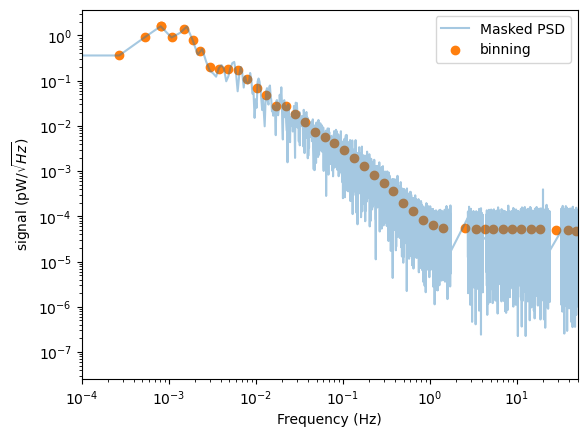

In [49]:
plt.loglog(f_mask, np.sqrt(pxx_mask[300]), alpha=0.4, label="Masked PSD")
plt.scatter(f_binned, np.sqrt(pxx_binned[300]), c='tab:orange', label="binning")
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('signal (pW/$\sqrt{Hz}$)')
plt.xlim(1E-4, 50)

### Binned PSD after demodultion

Text(0, 0.5, 'signal (pW/$\\sqrt{Hz}$)')

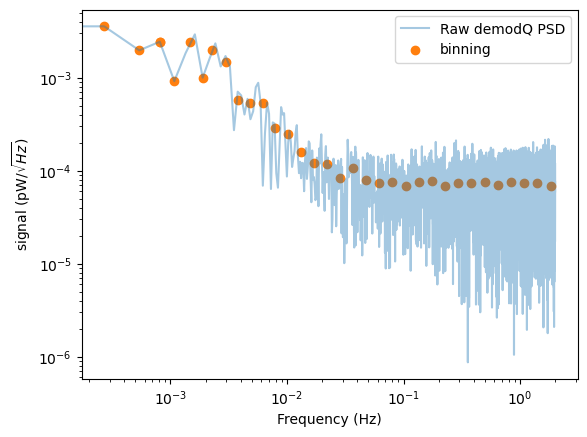

In [48]:
plt.figure()
plt.loglog(freqs_demodQ[freqs_demodQ<2], np.sqrt(pxx_demodQ[300][freqs_demodQ<2]), alpha=0.4, label="Raw demodQ PSD")
p = pxx_demod_binned[300][f_demod_binned<2]
f = f_demod_binned[f_demod_binned<2]
plt.scatter(f, np.sqrt(p), c='tab:orange', label="binning")
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('signal (pW/$\sqrt{Hz}$)')

## New features of fit_noise_model

* Minimum frequency for the fit can be decrared
* IndexError Exception is added to the Hessian calculation. IndexError occurs when the 1/f fit fails in the case where, for example, the signal is nan.
* Binning makes the calculation faster.

In [26]:
noise_fit_stats = fft_ops.fit_noise_model(aman, f=f_binned, pxx=pxx_binned, lowf=1, f_min=0.01, f_max=20, fwhite=(5, 20))

Cannot fit 1/f curve for detector sch_ufm_mv5_1707067412_0_194 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067412_0_274 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067412_0_380 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067485_1_038 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067485_1_042 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067485_1_202 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067485_1_326 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067485_1_454 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067599_2_005 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067599_2_112 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067599_2_197 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067599_2_304 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067756_3_099 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_17070

In [50]:
noise_fit_stats_demodQ = fft_ops.fit_noise_model(aman, f=f_demod_binned, pxx=pxx_demod_binned, lowf=0.1, f_max=2, fwhite=(0.1, 2))

Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_012 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_060 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_074 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_076 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_082 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_100 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_124 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_148 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_164 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_188 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067412_0_194 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_202 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_236 skipping.
Can

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:332: RuntimeWarning: invalid value encountered in power
  return w * (1 + (fknee / f) ** alpha)


Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_266 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067412_0_274 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_284 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_298 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_306 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_316 skipping.


/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:332: RuntimeWarning: invalid value encountered in power
  return w * (1 + (fknee / f) ** alpha)


Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_340 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_354 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067412_0_380 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_396 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_404 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_436 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_482 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067412_0_498 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067485_1_038 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067485_1_042 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067485_1_202 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067485_1_326 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067485_1_454 skipping.
Cannot calculate Hessia

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:332: RuntimeWarning: invalid value encountered in power
  return w * (1 + (fknee / f) ** alpha)


Cannot calculate Hessian for detector sch_ufm_mv5_1707067599_2_224 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067599_2_232 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067599_2_256 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067599_2_272 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067599_2_288 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067599_2_304 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067599_2_320 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067599_2_367 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067599_2_399 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067599_2_495 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_084 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_088 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067756_3_099 skipping.
Cannot 

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:332: RuntimeWarning: invalid value encountered in power
  return w * (1 + (fknee / f) ** alpha)


Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_216 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_277 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_299 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067756_3_300 skipping.


/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:332: RuntimeWarning: invalid value encountered in power
  return w * (1 + (fknee / f) ** alpha)


Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_364 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_395 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_467 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067756_3_472 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_485 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_499 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067756_3_509 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067906_4_042 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067906_4_048 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067906_4_059 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067906_4_061 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707067906_4_075 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707067906_4_096 skipping.
Cannot 

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:332: RuntimeWarning: invalid value encountered in power
  return w * (1 + (fknee / f) ** alpha)


Cannot fit 1/f curve for detector sch_ufm_mv5_1707068064_5_345 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707068064_5_355 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068064_5_358 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707068064_5_378 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707068064_5_422 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707068064_5_443 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068064_5_454 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068064_5_486 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707068064_5_507 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068224_6_000 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068224_6_136 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707068224_6_176 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068224_6_208 skipping.
Cannot fit 1/f curve for de

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:332: RuntimeWarning: invalid value encountered in power
  return w * (1 + (fknee / f) ** alpha)


Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_124 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707068377_7_132 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_133 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_146 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_166 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_186 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_204 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_217 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_268 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_282 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_284 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707068377_7_307 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_325 skipping.
Cannot calculate Hessian for detector sch_u

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:332: RuntimeWarning: invalid value encountered in power
  return w * (1 + (fknee / f) ** alpha)


Cannot calculate Hessian for detector sch_ufm_mv5_1707068377_7_409 skipping.
Cannot calculate Hessian for detector sch_ufm_mv5_1707068377_7_426 skipping.
Cannot fit 1/f curve for detector sch_ufm_mv5_1707068377_7_486 skipping.


### f_knee obtained from fitting

Text(0.5, 1.0, 'f_knee before demodulation')

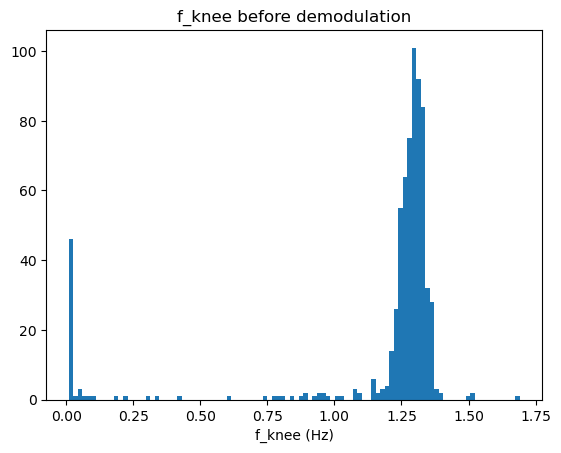

In [57]:
# Before demodulation
f_knee = noise_fit_stats.fit.T[0]
plt.figure()
plt.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100)
plt.xlabel('f_knee (Hz)')
plt.title('f_knee before demodulation')

Text(0.5, 1.0, 'f_knee after demodulation')

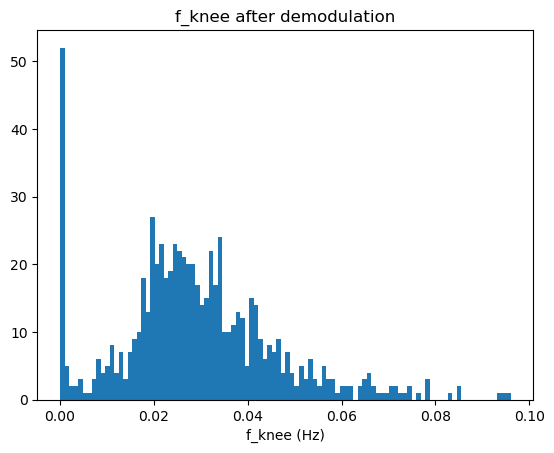

In [58]:
# After demodulation
f_knee = noise_fit_stats_demodQ.fit.T[0]
plt.figure()
plt.hist(f_knee[((f_knee>0)&(f_knee<0.1))], bins=100)
plt.xlabel('f_knee (Hz)')
plt.title('f_knee after demodulation')